In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
import pygenstability as pgs

from matplotlib.pyplot import figure
from pygenstability import plotting
from scipy.linalg import block_diag

from msfiltration import MCF

In [2]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Construct signle-scale SBM network

/tmp/ipykernel_33307/2020455119.py:9: FutureWarning:

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



<Figure size 432x288 with 0 Axes>

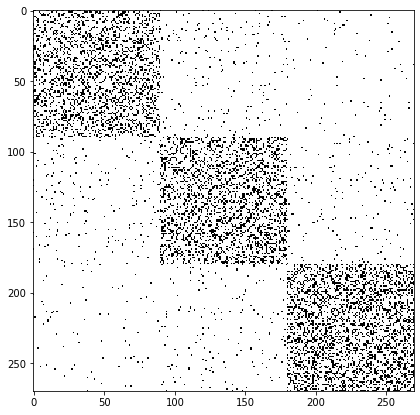

Graph named 'stochastic_block_model' with 270 nodes and 3696 edges


In [3]:
n = 270

# set a simple SBM model
sizes = [int(n/3), int(n/3), int(n/3)]
probs = [[0.25, 0.02, 0.01], [0.02, 0.25, 0.02], [0.01, 0.02, 0.3]]

G = nx.stochastic_block_model(sizes, probs, seed=1)

A = nx.adjacency_matrix(G).toarray()

# plot matrix
plt.figure()
figure(figsize=(8, 7))
plt.imshow(A, interpolation="nearest",cmap='binary')
plt.savefig(root_fig +'single_scale_SBM_adjacency_matrix.pdf', bbox_inches='tight')
plt.show()

print(G)

In [4]:
root_fig = '/home/tc/OneDrive/Software/MSFiltration/paper/figures/'
plt.rcParams.update({'font.size': 20})

# Apply MS analysis


In [5]:
# Set MS parameters
n_scale = 200
min_scale = -1.5
max_scale = 0.5

In [6]:
# # Run MS analysis
# MS_results = pgs.run(A,min_scale= min_scale,max_scale= max_scale,n_scale= n_scale,n_workers=4, constructor="continuous_normalized")

In [7]:
# Load data (deserialize)
with open("sSBM_MS_results.pkl", 'rb') as handle:
    MS_results = pickle.load(handle)

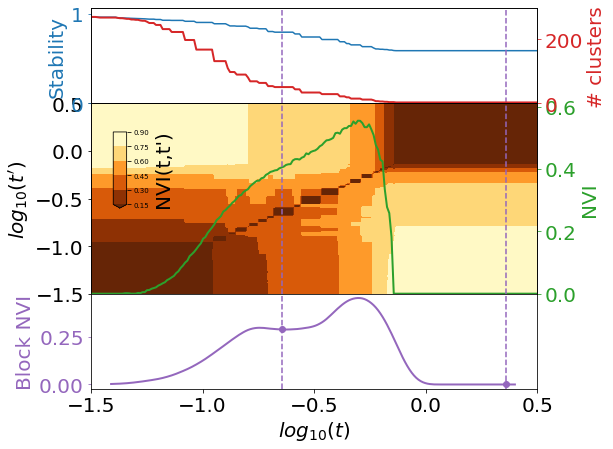

In [8]:
figure(figsize=(8, 7))
plotting.plot_scan(MS_results)
plt.show()

# Apply MCF

In [9]:
partitions = MS_results["community_id"]
log_scales = np.log10(MS_results['scales'])

In [10]:
n_partitions = len(partitions)
n_nodes = len(partitions[0])
partitions_matrix = np.zeros((n_nodes,n_partitions))

for i in range(0,n_partitions):
    partitions_matrix[:,i] = partitions[i]

partitions_matrix = np.asarray(partitions_matrix, dtype="int")

np.savetxt("sSBM_Partitions.csv", partitions_matrix.astype(int), fmt='%i', delimiter=',')

In [11]:
# initialise MCF object
mcf = MCF()
mcf.load_data(partitions,log_scales)

# build filtration and compute PH
mcf.build_filtration()
mcf.compute_persistence()

Constructing filtration with GUDHI ...


100%|██████████| 200/200 [00:09<00:00, 20.43it/s] 


Computing persistence with GUDHI ... 


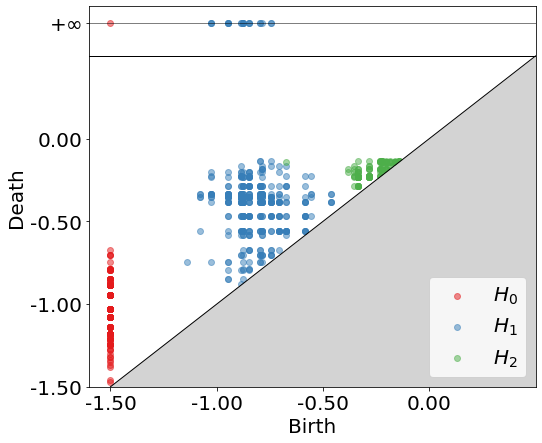

In [12]:
# Plot persistence diagram
ax = mcf.plot_persistence_diagram()

In [13]:
from msfiltration.measures import compute_persistent_hierarchy, compute_persistent_conflict, compute_beta_0, compute_partition_size, compute_birth_count, compute_death_count

[Text(0.5, 0, '$\\log(t)$'), (-0.1, 1.1)]

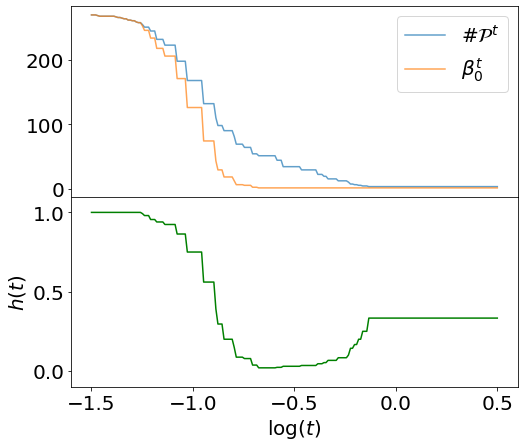

In [14]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.plot(log_scales,compute_partition_size(mcf), label = r'$\#\mathcal{P}^t$',alpha=0.7)#,ls=':')
ax1.plot(log_scales,compute_beta_0(mcf), label = r'$\beta_0^t$',alpha=0.7)#,ls=':')
ax1.set(xticks=[])

ax1.legend()

ax2.plot(log_scales,compute_persistent_hierarchy(mcf), label = r'$h(t)$',c='green')
ax2.set_ylabel(r'$h(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$',ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

In [15]:
h = compute_persistent_hierarchy(mcf)
h_bar = np.mean(h)
print("Average persistent hierarchy:", np.around(h_bar,3))

Average persistent hierarchy: 0.415


[Text(0.5, 0, '$\\log(t)$')]

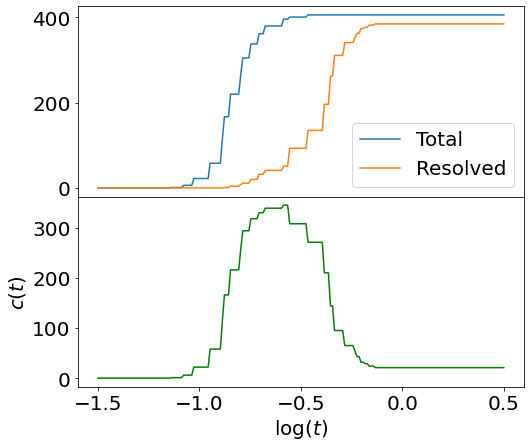

In [16]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,np.cumsum(compute_birth_count(mcf, 1)),label="Total")
ax1.plot(log_scales,np.cumsum(compute_death_count(mcf, 1)[:-1]),label="Resolved")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,np.cumsum(compute_birth_count(mcf, 1))-np.cumsum(compute_death_count(mcf, 1)[:-1]), label = r'$c(t)$',c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

[Text(0.5, 0, '$\\log(t)$')]

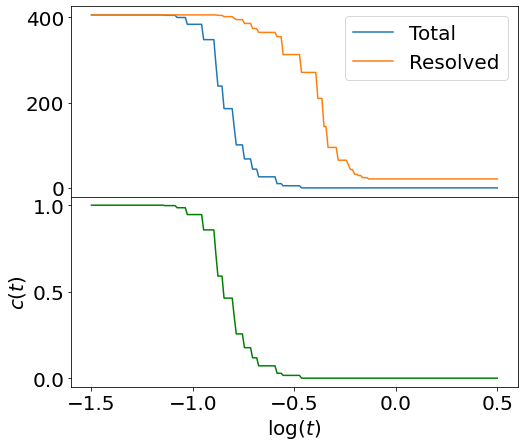

In [17]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,np.sum(compute_birth_count(mcf, 1))-np.cumsum(compute_birth_count(mcf, 1)),label="Total")
ax1.plot(log_scales,np.sum(compute_birth_count(mcf, 1))-np.cumsum(compute_death_count(mcf, 1)[:-1]),label="Resolved")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,(np.sum(compute_birth_count(mcf, 1))-np.cumsum(compute_birth_count(mcf, 1)))/(np.sum(compute_birth_count(mcf, 1))-np.cumsum(compute_death_count(mcf, 1)[:-1])), label = r'$c(t)$',c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')

In [18]:
c = np.nan_to_num(np.cumsum(compute_death_count(mcf, 1)[:-1])/np.cumsum(compute_birth_count(mcf, 1)),nan=1)
c_bar = np.mean(c)
print("Average persistent conflict:", np.around(c_bar,3))

Average persistent conflict: 0.618


/tmp/ipykernel_33307/895226029.py:1: RuntimeWarning:

invalid value encountered in divide



[Text(0.5, 0, '$\\log(t)$')]

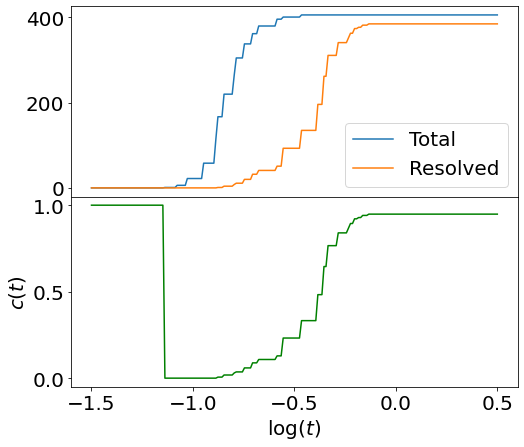

In [19]:
fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(log_scales,np.cumsum(compute_birth_count(mcf, 1)),label="Total")
ax1.plot(log_scales,np.cumsum(compute_death_count(mcf, 1)[:-1]),label="Resolved")
ax1.set(xticks=[])

ax1.legend()
ax2.plot(log_scales,c, label = r'$c(t)$',c='green')
ax2.set_ylabel(r'$c(t)$')#, color="green")
ax2.set(xlabel=r'$\log(t)$')#,ylim=(-0.1,1.1))
#ax2.legend()
#plt.savefig(root_fig +'SBM_persistence_hierarchy.pdf', dpi=fig.dpi,bbox_inches='tight')